# [MARKETING ANALYTICS] Modeling e Evaluation - Unsupervised Clusterization


**OBJETIVO DO PROJETO:**

O principal objetivo deste projeto é aumentar a eficácia das campanhas de marketing do banco.

**PREMISSAS:**

1. A análise considera apenas pessoas físicas, excluindo contas corporativas ou jurídicas.
2. Apenas clientes contactados durante a campanha mais recente são incluídos na análise, excluindo dados de campanhas anteriores.
3. Consideram-se apenas os contatos feitos via telefone celular e telefone fixo, excluindo outros meios de contato.


**FONTES INFORMACIONAIS:**

1. Dados das campanhas de marketing direto realizadas pelo banco, disponíveis no Bank Marketing Dataset da UCI Machine Learning Repository.
2. Indicadores econômicos, como taxa de variação de emprego, índice de preços ao consumidor, índice de confiança do consumidor e taxa Euribor de 3 meses.


**OBJETIVO(S) DO SCRIPT:**

Avaliar modelos preditivos no melhor cenário encontrado para identificar e caratcerizar segmentos de leads, utilizando variáveis como histórico de campanhas, idade, ocupação e método de contato preferido. Este modelo pode ser integrado ao CRM para priorizar esforços de venda e marketing.

O trabalho está seguindo a metodologia CRISP-DM e este script corresponde a fase de Modeling e Evaluation.



**CRITÉRIOS DE AVALIAÇÃO:**


Para comparar a performance dos modelos, utilizaremos as seguintes métricas de avaliação em ordem de importância:

1. F1-Score: Média harmônica entre precisão e recall.
1. ROC AUC (Área sob a Curva ROC): Medida da capacidade do modelo em distinguir entre as classes.
1. Explicabilidade: Quão fácil é explicar os resultados do modelo em algumas regras de negócio?
1. Precision (Precisão): Proporção de verdadeiros positivos em relação ao total de previsões positivas.
1. Recall (Sensibilidade): Proporção de verdadeiros positivos em relação ao total de positivos reais.
1. Acurácia: Proporção de previsões corretas em relação ao total de previsões.

Considerando que:

 - F1 Score é crucial porque balanceia precisão e sensibilidade, permitindo identificar de forma equilibrada clientes que converterão, sem inflar falsamente os números de conversão.
 - AUC-ROC é importante porque um bom desempenho nesta métrica assegura que o modelo está distinguindo bem entre os clientes que converterão e os que não converterão, o que é vital para a tomada de decisões estratégicas de marketing e para a alocação eficiente de recursos.
 - Explicabilidade é essencial para garantir que os modelos de previsão de conversão sejam não apenas precisos, mas também transparentes e justos. Ela aumenta a confiança, melhora a alocação de recursos, facilita a conformidade regulamentar e ajuda a identificar e mitigar vieses. Em última análise, um modelo explicável promove uma abordagem mais estratégica e ética em campanhas de marketing, resultando em melhores resultados físicos e financeiros.
 - Precisão é relevante porque, em marketing, alocar recursos para clientes que não converterão pode ser muito dispendioso.
 - Sensibilidade é relevante porque, para maximizar as conversões, é importante identificar o maior número possível de clientes que converterão.
 - Acurácia é a menos importante devido ao desequilíbrio das classes, o que pode fazer com que essa métrica seja menos representativa da performance real do modelo em identificar conversões.



## 1. BIBLIOTECAS E CONFIGURAÇÕES



### 1.1 BIBLIOTECAS

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


### 1.2 CONFIGURAÇÕES

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
sns.set_palette("muted")

### 1.3 FUNÇÕES

In [ ]:
def plot_elbow_davies(K, wcss, davies_bouldin):
    """
    Função para plotar os gráficos do método Elbow e da análise de Davies Bouldin usando seaborn.

    Parâmetros:
    K (list): Lista de valores de k (número de clusters).
    wcss (list): Valores de WCSS para cada k.
    davies_bouldin (list): Valores de Davies Bouldin para cada k.

    Retorna:
    None: A função gera e exibe os gráficos.
    """

    # Configura a figura e os subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Análise de Clusters: Elbow Method e Davies Bouldin')

    # Gráfico Elbow Method
    sns.lineplot(x=K, y=wcss, ax=axes[0])
    axes[0].set_xlabel('Número de Clusters (k)')
    axes[0].set_ylabel('WCSS')
    axes[0].set_title('Elbow Method')

    # Gráfico Davies Bouldin
    sns.lineplot(x=K, y=davies_bouldin, ax=axes[1])
    axes[1].set_xlabel('Número de Clusters (k)')
    axes[1].set_ylabel('Índice de Davies Bouldin')
    axes[1].set_title('Análise de Davies Bouldin')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
def plot_silhouette(df):
    """
    Função para gerar o gráfico de Silhouette para diferentes valores de k no KMeans.

    Parâmetros:
    df (DataFrame): O dataframe de entrada sem a coluna 'y'.

    Retorna:
    None: A função gera e exibe os gráficos de Silhouette em uma grade 3x3.
    """

    # Define a faixa de valores para k
    K = range(2, 11)

    # Configura o grid de subplots
    fig, axes = plt.subplots(3, 3, figsize=(14, 12))
    fig.suptitle('Análise de Clusters: Silhouette Plots', fontsize=16)

    for idx, k in enumerate(K):
        # Inicializa o modelo KMeans com o número de clusters k
        kmeans = KMeans(n_clusters=k, random_state=42)
        # Ajusta o modelo KMeans ao dataframe sem a coluna 'y'
        kmeans.fit(df)

        # Calcula as amostras de silhouette
        silhouette_vals = silhouette_samples(df, kmeans.labels_)
        # Calcula a pontuação média de silhouette para k
        silhouette_avg = silhouette_score(df, kmeans.labels_)

        y_lower, y_upper = 0, 0

        for i in range(k):
            cluster_silhouette_vals = silhouette_vals[kmeans.labels_ == i]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)
            axes.flat[idx].fill_betweenx(np.arange(y_lower, y_upper),
                                         0, cluster_silhouette_vals)
            y_lower += len(cluster_silhouette_vals)

        # Adiciona os títulos e rótulos
        axes.flat[idx].axvline(x=silhouette_avg, color="red", linestyle="--")
        axes.flat[idx].set_title(f"k = {k}")
        axes.flat[idx].set_xlabel("Valores de Silhouette")
        axes.flat[idx].set_ylabel("Cluster")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## 2. LEITURA DOS DADOS





### 2.1 OBTENÇÃO DOS DADOS

In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/manuelcalcada/marketing-analytics/main/1.%20dataset/df_train.csv', sep = ',', low_memory=False)
df_train.head()

,age,education,default,housing,loan,month,day_of_week,campaign,pdays,previous,euribor3m,y,generation,education_category,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_category_Autônomos,job_category_Não Empregados,job_category_Profissionais de Escritório,job_category_Trabalhadores Manuais,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_NA,poutcome_failure,poutcome_success
0,47,1,0,1,0,may,fri,2,0.0,1,1.313,0,1,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,True,False
1,29,6,0,1,0,jun,wed,1,0.0,0,1.260,1,3,3,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,True,False,True,False,False
2,57,6,1,0,0,aug,wed,2,0.0,0,4.965,0,1,3,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False,False
3,47,6,0,0,0,jun,thu,1,0.0,0,4.961,0,1,3,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False
4,42,6,0,0,0,aug,tue,2,0.0,0,4.968,0,2,3,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False,False


In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/manuelcalcada/marketing-analytics/main/1.%20dataset/df_test.csv', sep = ',', low_memory=False)
df_test.head()

,age,education,default,housing,loan,month,day_of_week,campaign,pdays,previous,euribor3m,y,generation,education_category,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_category_Autônomos,job_category_Não Empregados,job_category_Profissionais de Escritório,job_category_Trabalhadores Manuais,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_NA,poutcome_failure,poutcome_success
0,50,4,0,0,0,may,fri,1,0.0,0,4.855,0,1,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,True,True,False,False
1,40,5,0,0,0,aug,mon,3,0.0,0,4.963,0,2,2,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,True,False,True,False,False
2,38,3,0,0,0,may,fri,1,0.0,0,4.857,0,2,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False
3,42,2,1,0,0,jul,tue,1,0.0,0,4.962,0,2,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,True,False,False
4,33,2,0,1,1,may,tue,4,0.0,1,1.291,0,2,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,False,True,False


In [ ]:
df_val = pd.read_csv('https://raw.githubusercontent.com/manuelcalcada/marketing-analytics/main/1.%20dataset/df_val.csv', sep = ',', low_memory=False)
df_val.head()

,age,education,default,housing,loan,month,day_of_week,campaign,pdays,previous,euribor3m,y,generation,education_category,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_category_Autônomos,job_category_Não Empregados,job_category_Profissionais de Escritório,job_category_Trabalhadores Manuais,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_NA,poutcome_failure,poutcome_success
0,44,4,0,1,0,oct,fri,1,0.0,0,5.045,0,2,1,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False
1,42,4,0,1,1,oct,fri,1,0.0,0,5.045,1,2,1,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False
2,39,3,0,0,0,oct,fri,1,0.0,0,5.045,1,2,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,True,False,False
3,56,6,0,0,0,oct,fri,1,0.0,0,5.045,1,1,3,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False
4,30,6,0,0,0,oct,fri,1,0.0,0,5.045,1,2,3,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False


## 3. SEGMENTAÇÃO DE CLIENTES


Inicialmente serão testadas variáveis correspondentes aos leads, retirando informações de participação em campanhas anteriores ou na atual, assim como indicadores econômicos e variáveis temporais.


### 3.1 K-MEANS

In [ ]:
vars = ['age',
 'education',
 'default',
 'housing',
 'loan',
 'y', # somente para análise posterior
 'generation',
 'education_category',
 'job_category_Autônomos',
 'job_category_Não Empregados',
 'job_category_Profissionais de Escritório',
 'job_category_Trabalhadores Manuais',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'contact_cellular',
 'contact_telephone']

In [ ]:
df = pd.concat([df_train, df_test, df_val], axis=0)
df = df[vars]
df.head()

,age,education,default,housing,loan,y,generation,education_category,job_category_Autônomos,job_category_Não Empregados,job_category_Profissionais de Escritório,job_category_Trabalhadores Manuais,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone
0,47,1,0,1,0,0,1,0,False,False,False,True,False,False,True,True,False
1,29,6,0,1,0,1,3,3,False,False,True,False,False,False,True,True,False
2,57,6,1,0,0,0,1,3,False,False,True,False,False,True,False,True,False
3,47,6,0,0,0,0,1,3,False,False,True,False,False,True,False,False,True
4,42,6,0,0,0,0,2,3,False,False,True,False,False,True,False,True,False


In [ ]:
numeric_columns = df.drop(columns=['y']).select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])

#### 3.1.1 AVALIAÇÃO DO NÚMERO DE SEGMENTOS

In [ ]:
wcss = []
davies_bouldin = []
K = range(2,11)
for k in K:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(df_scaled.drop(columns=['y']))
  wcss.append(kmeans.inertia_)
  davies_bouldin.append(davies_bouldin_score(df_scaled.drop(columns=['y']), kmeans.labels_))

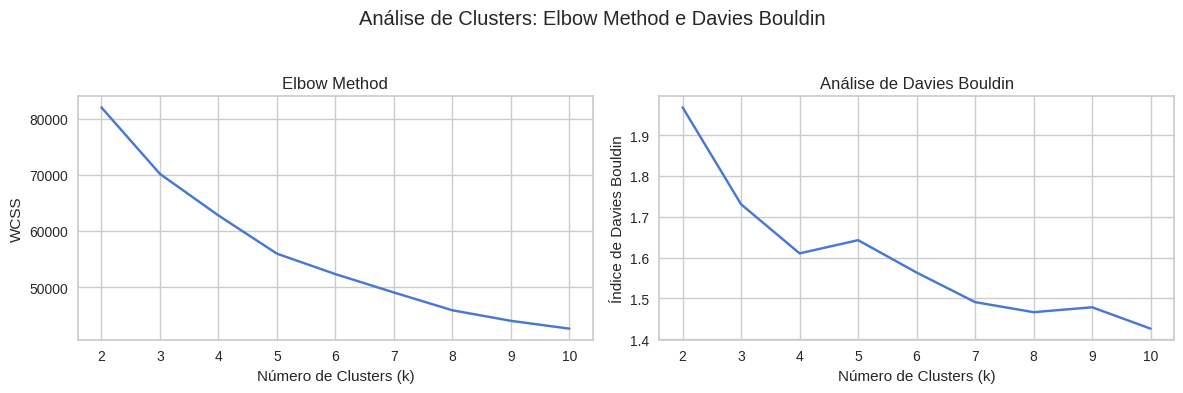

In [ ]:
plot_elbow_davies(K, wcss, davies_bouldin)

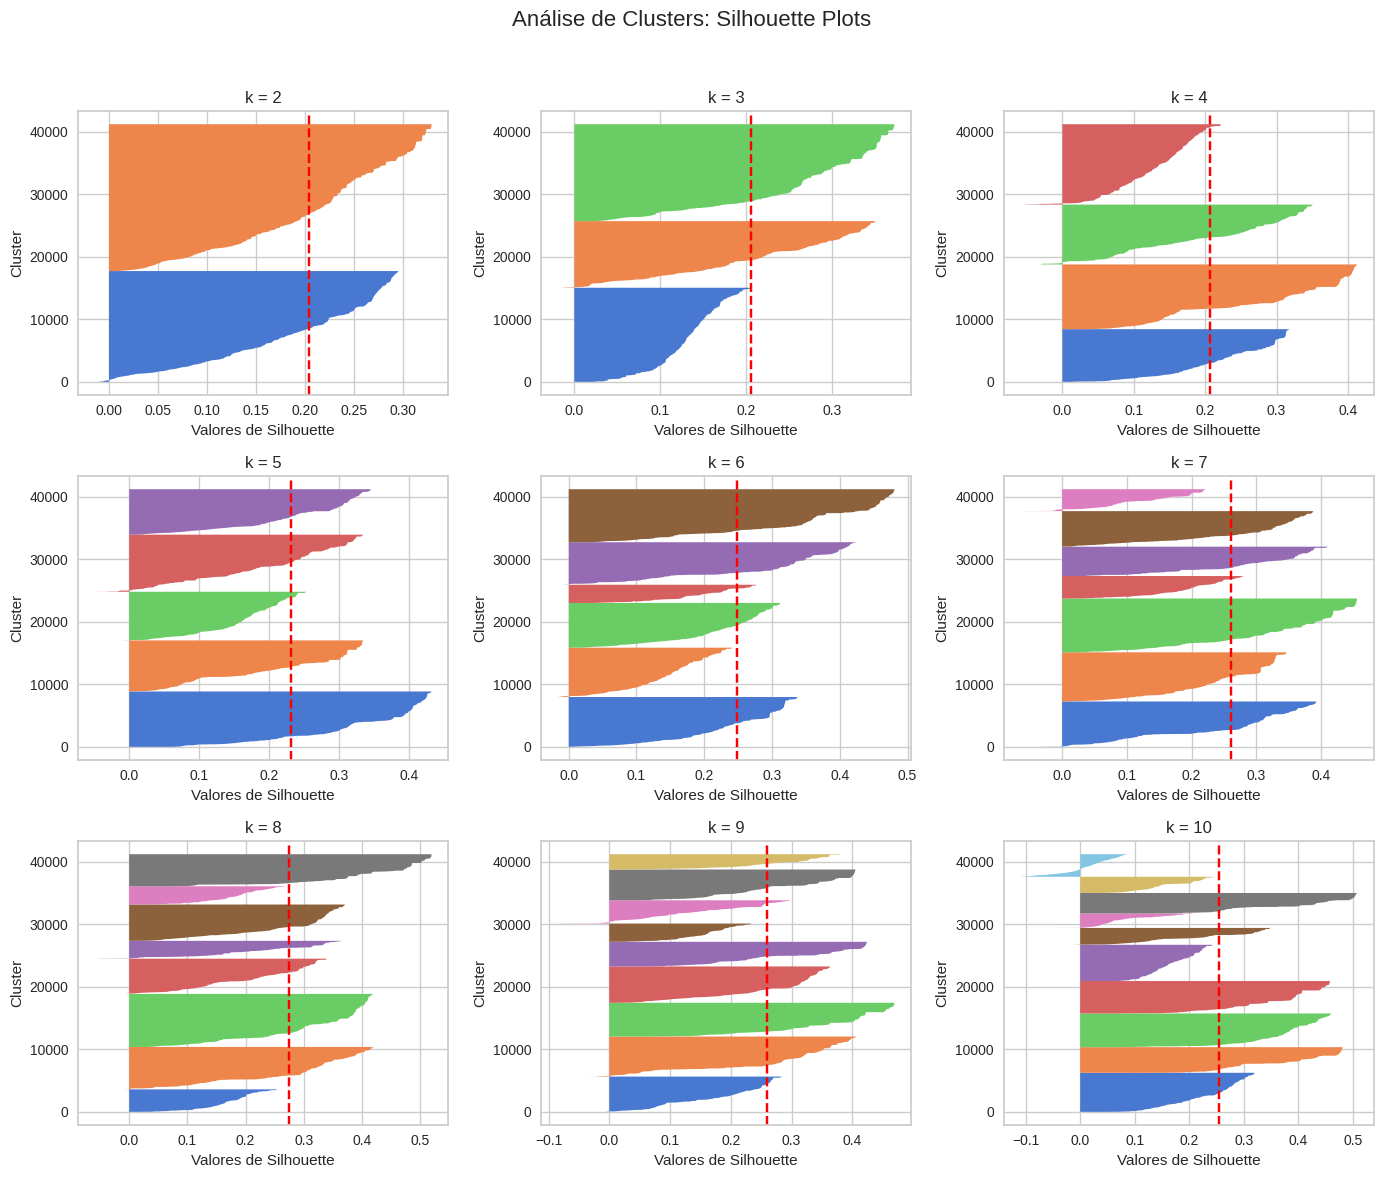

In [ ]:
plot_silhouette(df_scaled.drop(columns=['y']))

#### 3.1.2 RESULTADOS E CARACTERIZAÇÃO DOS GRUPOS

Pelo método do cotovelo, o número ideal de clusters situa-se entre 4 e 6, pois é nessa faixa que observamos uma redução significativa na taxa de diminuição do WCSS. Isso indica que adicionar mais clusters além desse ponto oferece retornos decrescentes em termos de compactação dos clusters.

Pelo método de Davies-Bouldin, o ideal seria utilizar mais de 7 clusters, já que o índice diminui à medida que o número de clusters aumenta, sugerindo uma melhor separação entre os grupos. No entanto, 4 clusters já apresentam um índice dentro de um intervalo aceitável.

Na análise de silhueta, um número de clusters entre 4 e 5 mostrou resultados satisfatórios, com uma distribuição adequada de casos em cada grupo e valores de silhueta médios que indicam uma boa coesão interna dos clusters.

Diante dessas análises, optamos por avaliar os resultados considerando entre 4 clusters.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(df_scaled.drop(columns=['y']))
df['cluster'] = kmeans.labels_

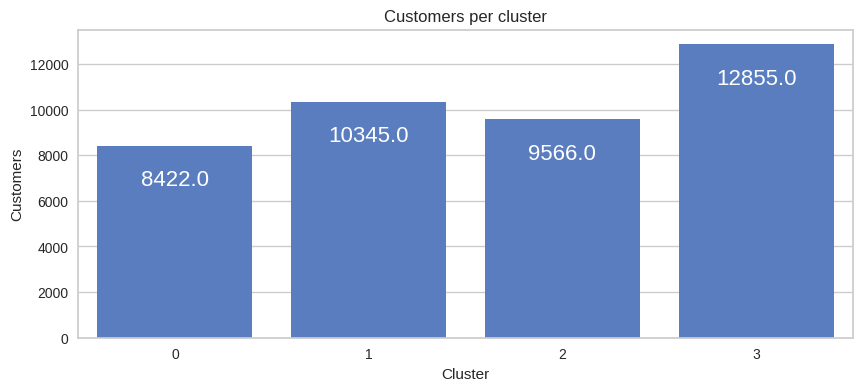

In [ ]:
plt.figure(figsize= (10, 4))
ax = sns.countplot(data= df, x= 'cluster')
plt.title('Customers per cluster')
plt.xlabel('Cluster')
plt.ylabel('Customers')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=16)
plt.show()

In [ ]:
df.groupby('cluster').mean().T.style.highlight_max(color = 'lightgreen', axis = 1)

cluster,0,1,2,3
age,32.989907,42.368101,42.196425,41.129599
education,5.145215,5.180957,2.827723,3.737456
default,0.087746,0.141808,0.257056,0.306107
housing,0.545120,0.553117,0.550387,0.466589
loan,0.157326,0.157854,0.150220,0.144146
y,0.157682,0.147994,0.119904,0.049319
generation,2.267751,1.673175,1.716810,1.767406
education_category,2.168250,2.218463,0.414489,1.102762
job_category_Autônomos,0.062099,0.078202,0.058436,0.076702
job_category_Não Empregados,0.122774,0.053939,0.117499,0.069467


### 3.2 PCA + K-MEANS

In [ ]:
vars = ['age',
 'education',
 'default',
 'housing',
 'loan',
 'y', # somente para análise posterior
 'generation',
 'education_category',
 'job_category_Autônomos',
 'job_category_Não Empregados',
 'job_category_Profissionais de Escritório',
 'job_category_Trabalhadores Manuais',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'contact_cellular',
 'contact_telephone']

In [ ]:
df = pd.concat([df_train, df_test, df_val], axis=0)
df = df[vars]

In [ ]:
numeric_columns = df.drop(columns=['y']).select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])

pca = PCA(n_components=0.90) # 90% da variância
principal_components = pca.fit_transform(df_scaled.drop(columns=['y']))
df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

pca.n_components_

8

In [ ]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.233907,-0.868948,1.154111,0.384256,-0.179039,-0.043603,-0.160616,-0.214488
1,-1.314266,-0.013979,0.541186,0.392663,-0.207575,-0.243065,-0.014917,-0.211239
2,-0.532399,-0.084676,-0.868646,-0.582137,0.600989,-0.615918,0.135109,-0.100459
3,-0.082484,1.153634,-0.729674,-0.412302,-0.209778,0.099996,-0.010476,-0.112265
4,-0.731701,-0.078150,-0.776884,-0.596619,-0.189032,-0.025656,-0.058200,-0.123588


#### 3.2.1 AVALIAÇÃO DO NÚMERO DE SEGMENTOS

In [ ]:
wcss = []
davies_bouldin = []
K = range(2,11)
for k in K:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(df_pca)
  wcss.append(kmeans.inertia_)
  davies_bouldin.append(davies_bouldin_score(df_pca, kmeans.labels_))

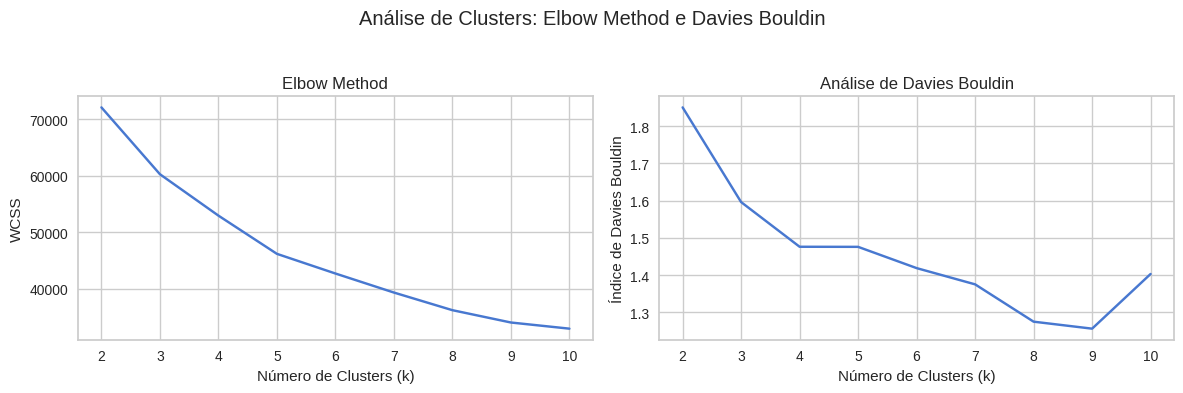

In [ ]:
plot_elbow_davies(K, wcss, davies_bouldin)

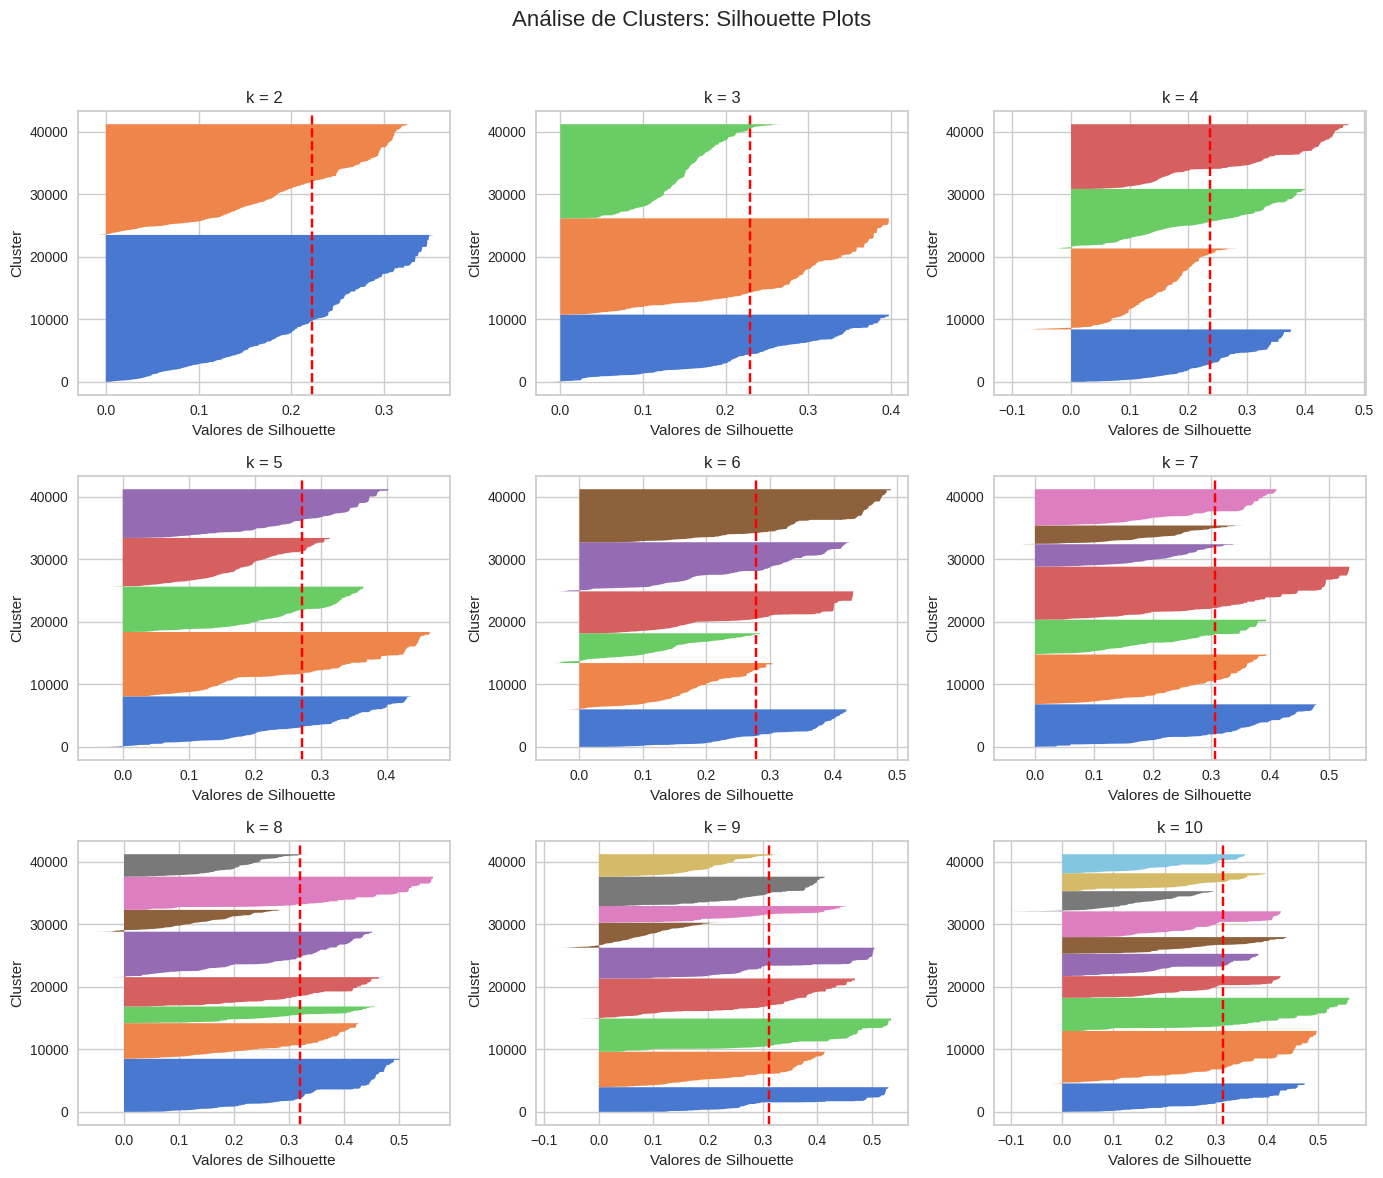

In [ ]:
plot_silhouette(df_pca)

#### 3.1.2 RESULTADOS E CARACTERIZAÇÃO DOS GRUPOS

Desta vez, ao utilizar a curva do cotovelo e o método das silhuetas, observamos que um bom resultado pode ser alcançado com 5 grupos para os dados transformados pelo PCA, retendo 90% da variabilidade original.
A média do valor da silhueta foi superior em comparação ao k-means sem PCA, indicando uma melhor qualidade na segmentação ao utilizar essa abordagem

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(df_pca)
df['cluster'] = kmeans.labels_

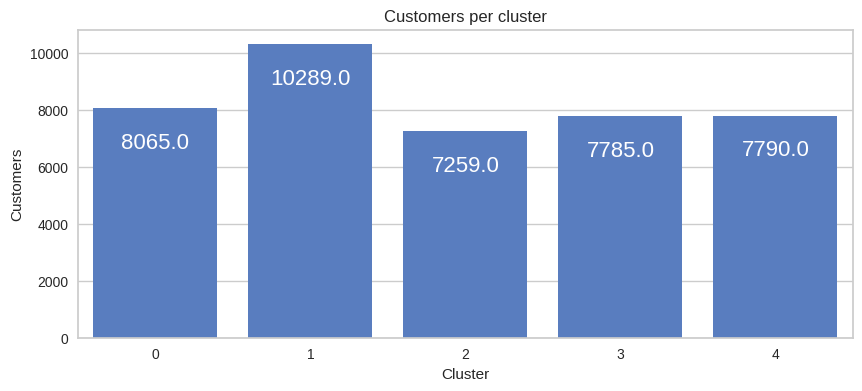

In [ ]:
plt.figure(figsize= (10, 4))
ax = sns.countplot(data= df, x= 'cluster')
plt.title('Customers per cluster')
plt.xlabel('Cluster')
plt.ylabel('Customers')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=16)
plt.show()

In [ ]:
df.groupby('cluster').mean().T.style.highlight_max(color = 'lightgreen', axis = 1)

cluster,0,1,2,3,4
age,44.181525,42.323355,40.334068,39.921387,32.496662
education,2.742963,5.181942,2.803967,4.997303,4.791784
default,0.292622,0.137137,0.373467,0.195504,0.076508
housing,0.547675,0.553309,0.461496,0.474502,0.567651
loan,0.150899,0.157838,0.143270,0.147335,0.156611
y,0.117669,0.147828,0.046012,0.058189,0.177535
generation,1.592808,1.675381,1.821050,1.845729,2.295122
education_category,0.394420,2.219652,0.399504,2.050739,1.857253
job_category_Autônomos,0.072288,0.076295,0.059650,0.089403,0.048780
job_category_Não Empregados,0.141104,0.051123,0.080452,0.064611,0.110141


## 4. RESULTADO FINAL DA SEGMENTAÇÃO

Considerando os resultados anteriores, seguiremos com o modelo de K-means que utiliza o PCA para redução de dimensionalidade. Com base nisso, conseguimos traçar os seguintes perfis:

**CLUSTER 0 - Experientes**:
- Leads mais velhos
- Pouca educação formal
- Alta inaidmplência
- Composto majoritariamente de trabalhadores manuais mas com alta representação de não-empregados, sobretudo de aposentados
- Quase todos são casados
- Contato preferencial pelo celular
- **Média conversão**

**CLUSTER 1 - Executivos**:
- Leads mais velhos
- Altíssima educação formal
- Baixa inaidmplência
- Composto majoritariamente de profissionais de escritório
- Todos são ou foram casados
- Contato preferencial pelo celular
- **Média-Alta conversão**

**CLUSTER 2 - Tradicionaiss**:
- Pouca educação formal
- Alta inaidmplência
- Composto majoritariamente de trabalhadores manuais
- A maioria são casados
- Contato preferencial pelo telefone fixo
- **Baixíssima conversão**

**CLUSTER 3 - Versáteis**:
- Alta educação formal
- Média inaidmplência
- Composto majoritariamente de profissionais de escritório mas com alta representação de autônomos
- A maioria são casados mas com alta representatividade de solteiros
- Contato preferencial pelo telefone fixo
- **Baixíssima conversão**


**CLUSTER 4 - Jovens em Ascensão**:
- Leads mais jovens
- Alta educação formal
- Baixíssima inaidmplência
- Boa representatividade de trabalhadores de escritórios, trabalhadores manuais de maior renda e estudantes
- Solteiros
- Contato preferencial pelo telefone celular
- **Alta conversão**

## 4. RECOMENDAÇÕES

Para segmentar a mensagem, canal e produto a fim de otimizar a campanha para cada público, recomendamos as seguintes personalizações:


**Experientes**

- **Benefícios de Estabilidade**: Promova a segurança e estabilidade do depósito como uma forma de complementar a aposentadoria ou poupar para o futuro.
- **Simplicidade e Facilidade de Acesso**: Ofereça um processo simplificado, com suporte para sanar dúvidas rapidamente via celular, já que a educação formal é baixa.

**Executivos**

- **Ofertas Exclusivas**: Apresente o depósito como um produto premium, destacando benefícios exclusivos e taxas de retorno mais altas, apelando ao senso de valor agregado.
- **Consultoria Personalizada**: Ofereça serviços de consultoria financeira, enfatizando estratégias de investimento que complementem o depósito, algo que ressoe com seu alto nível de educação.

**Tradicionais**

- **Condições de Acesso Facilitadas**: Ofereça condições especiais para quem enfrenta dificuldades financeiras, como depósitos com valor inicial mais baixo ou flexibilidade em saques.
- **Campanhas Educativas**: Crie campanhas que expliquem de forma simples e direta os benefícios do depósito, usando linguagem acessível e exemplos práticos.

**Versáteis**

- **Flexibilidade e Personalização**: Destaque a flexibilidade do depósito para atender às necessidades de profissionais com rendas variáveis, como autônomos.
- **Comunicação Assertiva**: Use uma abordagem mais direta e técnica nas comunicações, focando em dados e números que mostrem o retorno do investimento.

**Jovens em Ascensão**

- **Ofertas de Longo Prazo**: Promova o depósito como uma maneira inteligente de começar a poupar cedo, com foco em metas de longo prazo como comprar uma casa ou financiar estudos adicionais.
- **Campanhas Digitais e Gamificadas**: Use campanhas digitais e gamificadas que ressoem com o estilo de vida conectado e a familiaridade com tecnologia desse grupo.
- **Incentivos de Carreira**: Ofereça pacotes que combinem o depósito com oportunidades de crescimento profissional, como cursos ou parcerias com instituições educacionais.